In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder, FunctionTransformer, Binarizer)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings

# Filter out warnings
warnings.filterwarnings('ignore', category=UserWarning)  # General UserWarnings
warnings.filterwarnings('ignore', category=FutureWarning)  # FutureWarnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # DeprecationWarnings


In [34]:
data=pd.read_csv("Sleep_Efficiency.csv")

In [35]:
data.drop("ID",axis=1,inplace=True)

Text(0, 0.5, 'Sleep efficiency')

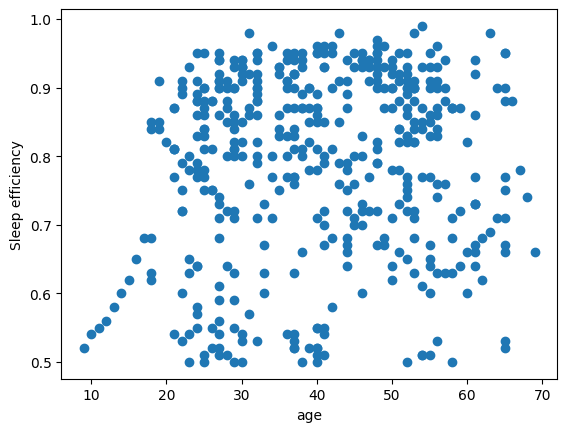

In [36]:
plt.scatter(data.Age, data['Sleep efficiency'])
plt.xlabel('age')
plt.ylabel('Sleep efficiency')

Text(0, 0.5, 'Sleep efficiency')

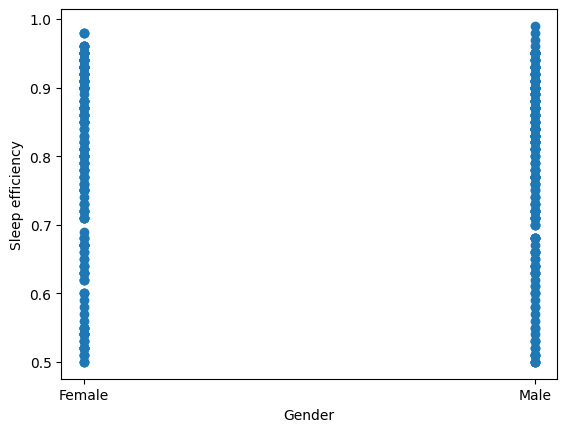

In [37]:
plt.scatter(data.Gender, data['Sleep efficiency'])
plt.xlabel('Gender')
plt.ylabel('Sleep efficiency')

Text(0, 0.5, 'Sleep efficiency')

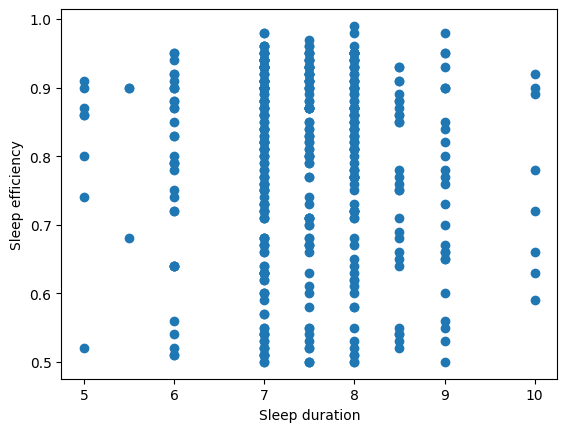

In [38]:
plt.scatter(data['Sleep duration'], data['Sleep efficiency'])
plt.xlabel('Sleep duration')
plt.ylabel('Sleep efficiency')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     452 non-null    int64  
 1   Gender                  452 non-null    object 
 2   Bedtime                 452 non-null    object 
 3   Wakeup time             452 non-null    object 
 4   Sleep duration          452 non-null    float64
 5   Sleep efficiency        452 non-null    float64
 6   REM sleep percentage    452 non-null    int64  
 7   Deep sleep percentage   452 non-null    int64  
 8   Light sleep percentage  452 non-null    int64  
 9   Awakenings              432 non-null    float64
 10  Caffeine consumption    427 non-null    float64
 11  Alcohol consumption     438 non-null    float64
 12  Smoking status          452 non-null    object 
 13  Exercise frequency      446 non-null    float64
dtypes: float64(6), int64(4), object(4)
memory 

In [40]:
categorial_cols = ['Gender', 'Smoking status']
num_cols = ['Age','Sleep duration',"Sleep efficiency",'REM sleep percentage','Deep sleep percentage','Light sleep percentage',
                'Awakenings','Caffeine consumption','Alcohol consumption','Exercise frequency']



corr=data[num_cols].corr()
cmap=sns.diverging_palette(5,250,as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .format(precision=2)

,Age,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Exercise frequency
Age,1.00,-0.06,0.10,0.04,0.02,-0.03,-0.02,-0.17,0.05,0.07
Sleep duration,-0.06,1.00,-0.03,-0.02,-0.04,0.04,0.00,-0.01,-0.05,-0.07
Sleep efficiency,0.10,-0.03,1.00,0.06,0.79,-0.82,-0.56,0.07,-0.39,0.26
REM sleep percentage,0.04,-0.02,0.06,1.00,-0.21,-0.02,-0.03,0.06,-0.05,0.03
Deep sleep percentage,0.02,-0.04,0.79,-0.21,1.00,-0.97,-0.31,0.00,-0.36,0.18
Light sleep percentage,-0.03,0.04,-0.82,-0.02,-0.97,1.00,0.32,-0.02,0.38,-0.19
Awakenings,-0.02,0.00,-0.56,-0.03,-0.31,0.32,1.00,-0.11,0.21,-0.22
Caffeine consumption,-0.17,-0.01,0.07,0.06,0.00,-0.02,-0.11,1.00,-0.12,-0.07
Alcohol consumption,0.05,-0.05,-0.39,-0.05,-0.36,0.38,0.21,-0.12,1.00,0.01
Exercise frequency,0.07,-0.07,0.26,0.03,0.18,-0.19,-0.22,-0.07,0.01,1.00


In [41]:
data.drop(['Bedtime','Wakeup time'], axis=1,inplace=True)

In [42]:
X=data.drop("Sleep efficiency", axis=1)
Y=data["Sleep efficiency"]

In [43]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.2)

### Defining preprocession and transformation

In [44]:
numeric_cols = ['Age','Sleep duration','REM sleep percentage','Deep sleep percentage','Light sleep percentage',
                'Awakenings','Caffeine consumption','Alcohol consumption','Exercise frequency']


categorial_cols = ['Gender', 'Smoking status']


In [45]:
categorial_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(transformers=[
    ('cat', categorial_transformer, categorial_cols),
    ('num', numeric_transformer, numeric_cols)
])

### Applying popular ML algorithms and calculating MAE and other performace matrices


In [46]:


# Assuming preprocessor, X_train, Y_train, X_test, Y_test, and X, Y are already defined

# Define regression models
algos = [LinearRegression(),
         DecisionTreeRegressor(),
         RandomForestRegressor(),
         XGBRegressor()
        ]

# Initialize the dataframe to store the results
new_df = {'Model':[], 'MAE in train':[], 'MAE in test': [], 'Cross Val score': [],
          'MSE in train': [], 'MSE in test': [],
          'R2 Score in train': [], 'R2 Score in test': [],
          'Accuracy in train': [], 'Accuracy in test': [],
          'Precision in train': [], 'Precision in test': [],
          'Recall in train': [], 'Recall in test': [],
          'F1 Score in train': [], 'F1 Score in test': []}

# Define a threshold for discretization
threshold = 0.5  # You may need to adjust this based on your data

for model in algos:
    my_pipe = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    
    my_pipe.fit(X_train, Y_train)
    Y_pred_train = my_pipe.predict(X_train)
    Y_pred_test = my_pipe.predict(X_test)
    
    # Convert continuous predictions to binary classifications for demonstration
    binarizer = Binarizer(threshold=threshold)
    Y_train_binary = binarizer.fit_transform(Y_train.values.reshape(-1, 1))
    Y_test_binary = binarizer.transform(Y_test.values.reshape(-1, 1))
    Y_pred_train_binary = binarizer.transform(Y_pred_train.reshape(-1, 1))
    Y_pred_test_binary = binarizer.transform(Y_pred_test.reshape(-1, 1))
    
    # Common metrics
    model_name = str(model).split('(')[0]
    new_df['Model'].append(model_name)
    
    # Regression metrics
    new_df["MAE in train"].append(mean_absolute_error(Y_train, Y_pred_train))
    new_df["MAE in test"].append(mean_absolute_error(Y_test, Y_pred_test))
    new_df["MSE in train"].append(mean_squared_error(Y_train, Y_pred_train))
    new_df["MSE in test"].append(mean_squared_error(Y_test, Y_pred_test))
    new_df["R2 Score in train"].append(r2_score(Y_train, Y_pred_train))
    new_df["R2 Score in test"].append(r2_score(Y_test, Y_pred_test))
    
    # Classification metrics
    new_df["Accuracy in train"].append(accuracy_score(Y_train_binary, Y_pred_train_binary))
    new_df["Accuracy in test"].append(accuracy_score(Y_test_binary, Y_pred_test_binary))
    new_df["Precision in train"].append(precision_score(Y_train_binary, Y_pred_train_binary, average='weighted'))
    new_df["Precision in test"].append(precision_score(Y_test_binary, Y_pred_test_binary, average='weighted'))
    new_df["Recall in train"].append(recall_score(Y_train_binary, Y_pred_train_binary, average='weighted'))
    new_df["Recall in test"].append(recall_score(Y_test_binary, Y_pred_test_binary, average='weighted'))
    new_df["F1 Score in train"].append(f1_score(Y_train_binary, Y_pred_train_binary, average='weighted'))
    new_df["F1 Score in test"].append(f1_score(Y_test_binary, Y_pred_test_binary, average='weighted'))

    # Cross-validation score for MAE
    new_df["Cross Val score"].append(-1 * cross_val_score(my_pipe, X, Y, cv=5, scoring='neg_mean_absolute_error').mean())

# Convert the results dictionary to a DataFrame
new_df = pd.DataFrame(new_df)

# Display the DataFrame
print(new_df)


                   Model  MAE in train  MAE in test  Cross Val score  \
0       LinearRegression      0.048599     0.049442         0.049505   
1  DecisionTreeRegressor      0.000166     0.050659         0.050492   
2  RandomForestRegressor      0.014364     0.038918         0.039204   
3           XGBRegressor      0.001754     0.040514         0.042010   

   MSE in train  MSE in test  R2 Score in train  R2 Score in test  \
0      0.003623     0.003686           0.813307          0.729183   
1      0.000005     0.004975           0.999743          0.634466   
2      0.000392     0.002501           0.979810          0.816257   
3      0.000011     0.002903           0.999419          0.786660   

   Accuracy in train  Accuracy in test  Precision in train  Precision in test  \
0           0.972299          1.000000            0.968699                1.0   
1           1.000000          0.989011            1.000000                1.0   
2           0.977839          1.000000            

In [47]:
new_df

,Model,MAE in train,MAE in test,Cross Val score,MSE in train,MSE in test,R2 Score in train,R2 Score in test,Accuracy in train,Accuracy in test,Precision in train,Precision in test,Recall in train,Recall in test,F1 Score in train,F1 Score in test
0,LinearRegression,0.048599,0.049442,0.049505,0.003623,0.003686,0.813307,0.729183,0.972299,1.000000,0.968699,1.0,0.972299,1.000000,0.970360,1.000000
1,DecisionTreeRegressor,0.000166,0.050659,0.050492,0.000005,0.004975,0.999743,0.634466,1.000000,0.989011,1.000000,1.0,1.000000,0.989011,1.000000,0.994475
2,RandomForestRegressor,0.014364,0.038918,0.039204,0.000392,0.002501,0.979810,0.816257,0.977839,1.000000,0.956170,1.0,0.977839,1.000000,0.966883,1.000000
3,XGBRegressor,0.001754,0.040514,0.042010,0.000011,0.002903,0.999419,0.786660,0.986150,1.000000,0.986343,1.0,0.986150,1.000000,0.983050,1.000000
